In [ ]:
import os
import sys
import IPython

sys.path.insert(0,os.path.join('/project/venv/lib/python3.8/site-packages/'))
sys.path.insert(0,os.path.join('/venv/lib/python3.8/site-packages'))

def ignore_user_installs(username):
    ## avoid using user installs
    user_install_path = '/scratch/' + username + '/python/lib/python3.8/site-packages'
    if user_install_path in sys.path:
        sys.path.remove(user_install_path)

ignore_user_installs("starzew")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

import pandas as pd
import glob
from pandas.core.common import flatten
from scipy.io import wavfile
from scipy.io.wavfile import write
import soundfile
import torch
from torch.utils.data import Dataset
from IPython.display import Audio
import librosa
import dill
import numpy as np
from speechbrain.dataio.dataio import read_audio_multichannel
from speechbrain.processing.features import STFT, ISTFT
from speechbrain.processing.multi_mic import Covariance
from speechbrain.processing.multi_mic import GccPhat
from speechbrain.processing.multi_mic import DelaySum
from collections import Counter
from matplotlib import pyplot as plt
import torchaudio
import matplotlib.pyplot as plt

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


# Prepare UASpeech Dataset

In [2]:
def load_pkl(file_name):
    with open(file_name, 'rb') as inp:
        data = dill.load(inp)
        
    return data

In [3]:
# returns 1. ...speakerID, 2. BlockID, 3. filename, 4. microphone
def name_parts(name):
    parts = name.split("_")
    # remove .wav
    parts[-1] = parts[-1].split(".")[0]
    return parts

In [4]:
# trim leading and trailing silence, keep 0.2 secs = 3200 values of silence before and after word
def trim(example):
    trimmed = librosa.effects.trim(np.array(example), top_db=30)
    lower_border = trimmed[1][0]-3200
    if lower_border < 0: lower_border = 0
    trimmed = example[lower_border: trimmed[1][1]+3200]
    return np.array(trimmed)

In [ ]:
def process_severity(speaker_id):
    #print(f"speakerid: {speaker_id}")
    ids_v_l = ["M01", "M04", "F03", "M12"]
    ids_l = ["M07", "F02", "M16"]
    ids_m = ["M05", "F04", "M11"]
    ids_h = ["M08", "M09", "M10", "F05", "M14"]
    severities = ["v_l", "l", "m", "h"]

    if "C" in speaker_id:
        return "c"
    elif speaker_id == "M13":
        return "unk"
    
    for i, sev in enumerate([ids_v_l, ids_l, ids_m, ids_h]):
        if speaker_id in sev:
            return severities[i]

In [6]:
class UASpeechDataset(Dataset):
    def __init__(self, audio_paths):
        self.audio_paths = audio_paths

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # get audio
        audio_path = self.audio_paths[idx]
        _, audio = wavfile.read(audio_path)
        #trim audio
        audio = trim(audio)
        # extract speaker_id, block_id, transcription
        parts = name_parts(audio_path)
        speaker_id = parts[0].split("/")[-1]
        blockID = parts[1]
        if "UW" in parts[2]:
            filename = blockID + "_" + parts[2]
        else:
            filename = parts[2]
        transcription = filename_word[filename]
        # get severity
        severity = process_severity(speaker_id)

        sample = {'audio': audio, 'speaker_id': speaker_id, 'severity': severity, 'transcription': transcription, 'block_id': blockID}

        return sample

In [38]:
def get_data_paths(data_path):
    # get all paths from data_path and append audio paths to list
    data_paths = []
    for path in glob.glob(data_path + "/*"):
        data_paths.append(glob.glob(path + '/*'))

    data_paths = list(flatten(data_paths))
    
    return data_paths

In [8]:
def get_audio_paths(data_paths, mic):
    audio_paths = []
    # choose only audio samples from microphone 5 -> located in the middle
    for path in data_paths:
        if mic in path:
            audio_paths.append(path)
    
    return audio_paths

In [9]:
def beamform(xs_speech, fs):
    stft = STFT(sample_rate=fs)
    cov = Covariance()
    gccphat = GccPhat()
    delaysum = DelaySum()
    istft = ISTFT(sample_rate=fs)

    Xs = stft(xs_speech)
    XXs = cov(Xs)
    tdoas = gccphat(XXs)
    Ys_ds = delaysum(Xs, tdoas)
    ys_ds = istft(Ys_ds)
    
    return ys_ds.squeeze()

In [65]:
def merge_arrays(filename_word, data_paths, variant, remove_paths=[]):
    audio_paths = []
    missing = []
    fs = 16000

    speaker_ids = ["M01", "M04", "F03", "M12","M07", "F02", "M16","M05", "F04", "M11","M08", "M09", "M10", "F05", "M14"]
    control_ids = ["CF02", "CF03", "CF04", "CF05", "CM01", "CM04", "CM05", "CM06", "CM08", "CM09", "CM10", "CM12", "CM13"]

    for num, key in enumerate(filename_word.keys()):
        if num % 50 == 0:
            print("key num:", num)
        
        for idx in speaker_ids+control_ids:
            if "UW" not in key:
                for block in ["B1", "B2", "B3"]:
                    subpath = "/" + idx + "_" + block + "_" + key + "_"
                    if remove_paths is not None:
                        if subpath[1:-1] in remove_paths:
                            print("remove", subpath)
                            continue
                    file_paths = [path for path in data_paths if subpath in path ]
                    
                    # check if path could be found
                    if len(file_paths) == 0:
                        missing.append(subpath)
                        continue
                    
                    # check if all audios have same length
                    file_paths = check_filepaths(file_paths, variant)
                    
                    try:
                        xs_speech = read_audio_multichannel({"files": file_paths})
                        
                    except Exception as e:
                        print(e)
                        print(file_paths)
                    xs_speech = xs_speech.unsqueeze(0)
                    merged_audio = beamform(xs_speech, fs) 
                    
                    #print(merged_audio)
                    
                    
                    # save merged audio
                    #audio_path = f"/data/project/uaspeech/audiomerged{subpath[:-1]}.wav"
                    audio_path = f"/data/project/uaspeech/audiofinal{subpath[:-1]}.wav"
                    audio_paths.append(audio_path)
                    write(audio_path, fs, np.array(merged_audio))
                          
            else:
                subpath = "/" + idx + "_" + key + "_"
                if subpath[1:-1] in remove_paths:
                            print("remove", subpath)
                            continue
                file_paths = [path for path in data_paths if subpath in path ]
                
                # check if path could be found
                if len(file_paths) == 0:
                    missing.append(subpath)
                    continue
                    
                # check if all audios have same length
                file_paths = check_filepaths(file_paths, variant)
                    
                try:
                    xs_speech = read_audio_multichannel({"files": file_paths})
                except Exception as e:
                    print(e)
                    print(file_paths)
                xs_speech = xs_speech.unsqueeze(0)
                merged_audio = beamform(xs_speech, fs)
                
                
                #print(merged_audio)
                
                # save merged audio
                audio_path = f"/data/project/uaspeech/audiomerged{subpath[:-1]}.wav"
                audio_path = f"/data/project/uaspeech/audiofinal{subpath[:-1]}.wav"
                audio_paths.append(audio_path)
                write(audio_path, fs, np.array(merged_audio))
                    
                
    # save missing paths
    #with open('/data/project/uaspeech/missing_paths.pkl', 'wb') as outp:
    with open('/data/project/uaspeech/missing_paths_final.pkl', 'wb') as outp:
        dill.dump(missing, outp)
                    
    # save audiopaths
    #with open('/data/project/uaspeech/audio_paths.pkl', 'wb') as outp:
    with open('/data/project/uaspeech/audio_paths_final.pkl', 'wb') as outp:
        dill.dump(audio_paths, outp)


In [ ]:
def check_filepaths(file_paths, variant):
    #print("check")
    lengths = []
    audios = []
    for path in file_paths:
        _, audio = wavfile.read(path)
        lengths.append(len(audio))
        audios.append(audio)
    
    # count occurences of different length values
    c_values = list(Counter(lengths).keys())
    if len(c_values) == 1:
        return file_paths
    else:
        if variant=="short":
            # if there are more than one lengths, audios have to be cropped to shortest length for merging
            minlen = np.min(c_values)
            print(c_values,"crop audio to",minlen)

            for i,audio in enumerate(audios):
                audio = audio[:minlen]
                write(file_paths[i], 16000, audio.astype(np.int16))
        elif variant=="long":
            print("lengths",lengths)
            
            maxid = np.argmax(Counter(lengths).values())
            maxlen = c_values[maxid]
            ids = [i for i, length in enumerate(lengths) if length == maxlen]
            new_paths = [file_paths[i] for i in ids]
            return new_paths
    return 
        

In [ ]:
def missing_paths():
    speaker_ids = ["M01", "M04", "F03", "M12","M07", "F02", "M16","M05", "F04", "M11","M08", "M09", "M10", "F05", "M14"]
    control_ids = ["CF02", "CF03", "CF04", "CF05", "CM01", "CM04", "CM05", "CM06", "CM08", "CM09", "CM10", "CM12", "CM13"]

    for key in filename_word.keys():
        for idx in speaker_ids+control_ids:
            if "UW" not in key:
                for block in ["B1", "B2", "B3"]:
                    subpath4 = "/" + idx + "_" + block + "_" + key + "_M4.wav"
                    subpath5 = "/" + idx + "_" + block + "_" + key + "_M5.wav"
                    subpath6 = "/" + idx + "_" + block + "_" + key + "_M6.wav"
                    #print("subpath: ", subpath5)
                    path = [i for i in data_paths if subpath5 in i]
                    if len(path) == 0:
                        path = [i for i in data_paths if subpath4 in i]
                    if len(path) == 0:
                        path = [i for i in data_paths if subpath6 in i]
                    if len(path) == 0:
                        print("error: " + subpath5)
            else:
                subpath4 = "/" + idx + "_" + key + "_M4.wav"
                subpath5 = "/" + idx + "_" + key + "_M5.wav"
                subpath6 = "/" + idx + "_" + key + "_M6.wav"

                path = [i for i in data_paths if subpath5 in i]
                if len(path) == 0:
                    path = [i for i in data_paths if subpath4 in i]
                if len(path) == 0:
                    path = [i for i in data_paths if subpath6 in i]
                if len(path) == 0:
                    print("error: " + subpath5)

In [ ]:
def redo_merging(data_path, filename_word, variant):
    data_paths = get_data_paths(data_path)
    remove_paths = load_pkl("datasets/remove_paths.pkl")
    
    # merge wavs from microphone array
    merge_arrays(filename_word, data_paths, variant, remove_paths)
    
    

In [ ]:
def mic_data(data_path, mic): 
    data_paths = get_data_paths(data_path)
    audio_paths = get_audio_paths(data_paths, mic)
    
    # create dataset
    ua_dataset = UASpeechDataset(audio_paths)
    
    # save dataset
    with open(f'/data/project/uaspeech/ua_ds_{mic}.pkl', 'wb') as outp:
        dill.dump(ua_dataset, outp)

In [37]:
def mic_count():
    data_path = "/data/project/uatest" 
    data_paths = get_data_paths(data_path)
    
    mics = {
        "M2":0, 
        "M3":0, 
        "M4":0, 
        "M5":0, 
        "M6":0, 
        "M7":0, 
        "M8":0,   
        "Merged":0
    }
    
    for path in data_paths:
        mic = path[-6:-4]
        mics[mic] += 1
        
    audio_paths = load_pkl("/data/project/uaspeech/audio_paths.pkl")
    mics["Merged"] = len(audio_paths)
    
    return mics

In [16]:
def mic_hist(mics):
    plt.figure(figsize=(8,5))
    ax = plt.bar(mics.keys(), mics.values())
    plt.bar_label(ax, label_type='edge', fontsize=13)
    plt.ylabel("Amount of Samples", fontsize=13)
    plt.xlabel("Microphone", fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("Recorded Audios by Microphone", fontsize=13)
    plt.tight_layout()
    plt.show()

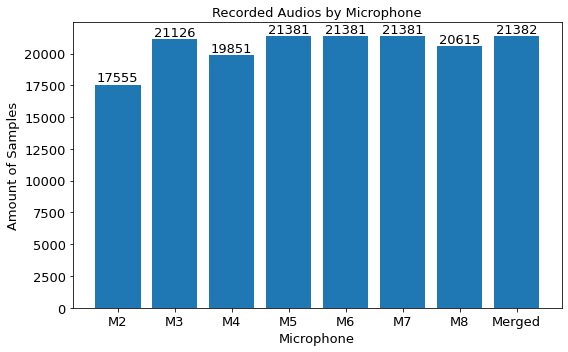

In [ ]:
mics = mic_count()
mic_hist(mics)

In [ ]:
mics_ohnem = mics
mics_ohnem.pop("Merged")

21382

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


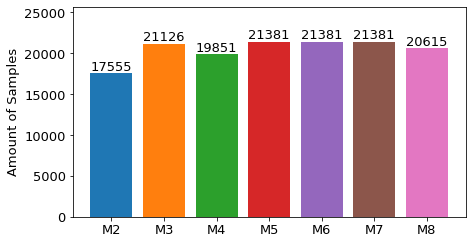

In [52]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
figure = plt.figure()
figure.set_figwidth(480*px)
figure.set_figheight(3.5)
cmap = plt.get_cmap('tab10')
ax = plt.bar(mics_ohnem.keys(), mics_ohnem.values(), color=cmap.colors)
plt.margins(y=0.2)
plt.bar_label(ax, label_type='edge', fontsize=13)
plt.ylabel("Amount of Samples", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig("figs/mic_distribution.pdf")
plt.show()

In [33]:
def plot_gender_dist():
    women = [4,4]
    men = [9,11]
    fs=13
    index = ["Control", "Dysarthric"]
    df = pd.DataFrame({"Female": women, "Male": men}, index=index)
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    
    df.plot.bar(rot=0, figsize=(480*px,3.5))
    #plt.xlabel("Group",fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.ylabel("Amount of Speakers",fontsize=fs)
    plt.legend(fontsize=fs,loc='upper center', bbox_to_anchor=(0.5, 1.2),ncols=2)
    #plt.title("Gender Distribution")
    plt.tight_layout()
    plt.savefig("figs/gender_distribution.pdf")
    plt.show()

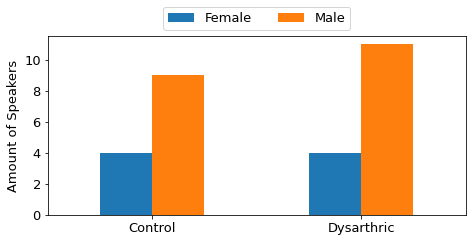

In [34]:
plot_gender_dist()

In [74]:
# dicts from word to abbreviation and other way around
word_filename = pd.read_excel("/data/project/uafiles/doc/speaker_wordlist.xls", sheet_name="Word_filename")
filename_word = word_filename[['FILE NAME', 'WORD']]
filename_word = dict(filename_word.values)

In [82]:
dict(word_filename)["WORD"][:20]

0       Three
1        Nine
2        Zero
3         Six
4       Seven
5       Eight
6        Four
7        Five
8         One
9         Two
10       Echo
11      Delta
12    Whiskey
13       Kilo
14     Sierra
15      Tango
16    Uniform
17      X-ray
18     Juliet
19    Charlie
Name: WORD, dtype: object

In [209]:
#data_path = "/data/project/uatest"
#mic_data(data_path, "M8")

In [54]:
#remove_paths = load_pkl("datasets/remove_paths.pkl")
#len(remove_paths)

220

In [70]:
#data_path = "/data/project/uatest"
#variant = "long"
#remove_paths = load_pkl("datasets/remove_paths.pkl")
#redo_merging(data_path,filename_word, variant)

key num: 0
remove /M01_B2_D0_
remove /M04_B1_D6_
remove /M01_B3_D5_
remove /M07_B1_LE_
remove /M05_B3_LK_
remove /M01_B2_LT_
remove /M01_B1_LU_
remove /M12_B2_LX_
remove /M01_B1_LZ_
remove /M01_B2_LZ_
remove /M07_B1_LR_
remove /M01_B2_LI_
remove /F02_B3_LI_
remove /M07_B2_LL_
remove /M01_B2_LV_
remove /M01_B1_LY_
remove /M01_B2_LG_
remove /M05_B1_LG_
remove /M07_B1_LO_
remove /M05_B2_LO_
remove /M12_B3_C3_
remove /M01_B1_C4_
remove /M07_B2_C4_
remove /M07_B2_C11_
remove /M05_B1_C13_
key num: 50
remove /M04_B2_C16_
remove /M01_B1_C17_
remove /M01_B1_CW2_
remove /M07_B1_CW2_
remove /M01_B1_CW6_
remove /M07_B1_CW7_
remove /M01_B1_CW14_
remove /M05_B1_CW14_
remove /M01_B2_CW16_
remove /M07_B2_CW16_
remove /M01_B1_CW17_
remove /M01_B2_CW25_
remove /M07_B2_CW26_
remove /M07_B1_CW27_
remove /M07_B1_CW29_
remove /F05_B1_CW36_
remove /M01_B3_CW37_
remove /M01_B3_CW38_
remove /M01_B1_CW39_
lengths [34983, 34983, 34983, 34983, 34983, 34985, 34983]
remove /M01_B2_CW42_
remove /M07_B2_CW42_
key num

In [67]:
# TODO: missing paths ansehen
#remove_paths = load_pkl("datasets/remove_paths.pkl")
#print(remove_paths)
#print(len(remove_paths))

220


In [196]:
#missing_paths = load_pkl("/data/project/uaspeech/missing_paths_test.pkl")
#print(missing_paths)
#print(len(missing_paths))

['/F03_B3_C1_', '/F03_B3_C2_', '/F03_B3_C3_', '/F03_B3_C4_', '/F03_B3_C5_', '/F03_B3_C6_', '/F03_B3_C7_', '/F03_B3_C8_', '/F03_B3_C9_', '/F03_B3_C10_', '/F04_B2_C10_', '/F03_B3_C11_', '/F04_B2_C11_', '/F03_B3_C12_', '/F04_B2_C12_', '/F03_B3_C13_', '/F03_B3_C14_', '/F03_B3_C15_', '/F03_B3_C16_', '/F03_B3_C17_', '/F03_B3_C18_', '/F03_B3_C19_', '/F03_B3_CW10_', '/F03_B3_CW11_', '/F03_B3_CW12_', '/F03_B3_CW13_', '/F03_B3_CW100_', '/F04_B1_UW9_', '/F04_B1_UW90_', '/F04_B1_UW91_', '/F04_B1_UW92_', '/F04_B1_UW93_', '/F04_B1_UW94_', '/F04_B1_UW95_', '/F04_B1_UW96_', '/F04_B1_UW97_', '/F04_B1_UW98_', '/F04_B1_UW99_']
38


-> es fehlen 38 Aufnahmen

In [71]:
# create dataset
#remove = True
#audio_paths = load_pkl("/data/project/uaspeech/audio_paths_final.pkl") 
#if remove:
#    remove_paths = load_pkl('datasets/remove_paths.pkl')
#    audio_paths = [i for i in audio_paths if i.split("/")[-1].split(".")[0] not in remove_paths]
#ua_dataset = UASpeechDataset(audio_paths)

In [72]:
#len(audio_paths)

21162

In [73]:
# save dataset
#with open('/data/project/uaspeech/ua_ds_final.pkl', 'wb') as outp:
#    dill.dump(ua_dataset, outp)

In [199]:
#sample_id = 170
#ua_dataset[sample_id]

{'audio': array([-5.8399682e-04, -7.0645625e-04, -1.4840225e-04, ...,
         3.0175015e-05,  1.6896409e-04,  4.5213298e-04], dtype=float32),
 'speaker_id': 'M01',
 'severity': 'v_l',
 'transcription': 'Zero',
 'block_id': 'B3'}

In [200]:
#Audio(ua_dataset[sample_id]['audio'], rate=16000)

In [36]:
test = pd.read_excel("/data/project/uafiles/doc/speaker_wordlist.xls")

In [37]:
test

,Unnamed: 0,Demographic information for speakers with dysarthria,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Speech,Dysarthria,NaN
2,Speaker,Age,Intelligibility (%),Diagnosis,Motor Control
3,NaN,NaN,NaN,NaN,NaN
4,M01,>18,Very low (15%),Spastic,Uses a wheelchair
5,NaN,NaN,NaN,NaN,NaN
6,M04,>18,Very low (2%),Spastic,"Uses a wheelchair, AAC and head devices"
7,NaN,NaN,NaN,NaN,NaN
8,M05,21,Mid (58%),Spastic,Uses a wheelchair
9,NaN,NaN,NaN,NaN,NaN


# Prepare LibriSpeech test-clean

In [4]:
def get_paths_libri(data_path):
    # get all paths from data_path and append audio paths to list
    data_paths = []
    txt_paths = []
    for path in glob.glob(data_path + "/*"):
        for mini_path in glob.glob(path + "/*"):
            data_paths.append(glob.glob(mini_path + '/*'))
            

    data_paths = list(flatten(data_paths))
    
    txt_paths = [path for path in data_paths if path.endswith("txt")]
    data_paths = [path for path in data_paths if path.endswith("flac")]
    
    return data_paths, txt_paths

In [5]:
def txt_to_dict(txt_paths):
    id2transcript = dict()

    for path in txt_paths:
        with open(path, "r") as f:
            lines = f.readlines()

        for line in lines:
            idx, transcript = line.split(" ", 1) 
            idx.strip() # removes leading and trailing whitespaces
            transcript.strip()
            if transcript.endswith("\n"):
                transcript = transcript.replace("\n", "")
            id2transcript[idx] = transcript
        
    return id2transcript

In [6]:
class LibriSpeechDataset(Dataset):
    def __init__(self, audio_paths, id2transcript):
        self.audio_paths = audio_paths
        self.id2transcript = id2transcript

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # get audio
        audio_path = self.audio_paths[idx]
        audio, sr = soundfile.read(audio_path)
        # get transcription
        idx = audio_path.split("/")[-1].split(".")[0]
        transcription = self.id2transcript[idx]

        sample = {'audio': audio, 'sr':sr, 'transcription': transcription}

        return sample

In [7]:
def create_save_libri():
    data_path_libri = "/data/share/public/LibriSpeech/test-clean"
    data_paths_libri, txt_paths = get_paths_libri(data_path_libri)
    id2transcript = txt_to_dict(txt_paths)

    libri_test_clean = LibriSpeechDataset(data_paths_libri, id2transcript)
    
    ds_ls = {
        "transcripts": [],
        "audio": []
    }
    
    for sample in libri_test_clean:
        ds_ls["transcripts"].append(sample["transcription"])
        ds_ls["audio"].append(sample["audio"])

    # save dataset
    with open('/data/project/librispeech/test-clean.pkl', 'wb') as outp:
        dill.dump(ds_ls, outp)

In [16]:
#create_save_libri()

In [8]:
ds_libri = load_pkl("/data/project/librispeech/test-clean.pkl")

In [18]:
idx = np.random.randint(len(ds_libri["transcripts"]))


In [19]:
print(ds_libri["transcripts"][idx])

ALEXANDER WENT OVER AND OPENED THE WINDOW FOR HER


In [23]:
idx = 859

In [22]:
ds_libri["transcripts"].index("THAT WON'T LAST IT WILL GO AWAY AND THINGS WILL BE JUST AS THEY USED TO")

859

In [15]:
IPython.display.Audio(np.float32(ds_libri["audio"][idx]), rate=16000)

<Figure size 480x288 with 0 Axes>

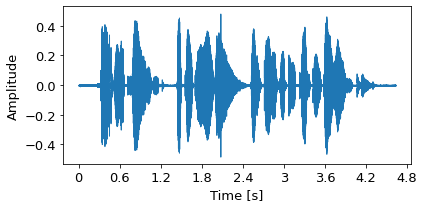

In [63]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure().set_figwidth(480*px)
plt.figure().set_figheight(3)

librosa.display.waveshow(np.float32(ds_libri["audio"][idx]), sr=16000)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Amplitude", fontsize=13)
plt.xlabel("Time [s]", fontsize=13)

#plt.legend(fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=5)
plt.tight_layout()
plt.savefig("figs/libri_wav.pdf")
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig.set_figwidth(480*px)
fig.set_figheight(8)
D = librosa.amplitude_to_db(np.abs(librosa.stft(ds_libri["audio"][idx])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=16000, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(ds_libri["audio"][idx], hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=16000, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
#fig.colorbar(img, ax=ax, format="%+2.f dB")

# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=ds_libri["audio"][idx], sr=16000, n_mels=128,
                                    fmax=8000)

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax[2])
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax[2].set(title='Mel-frequency spectrogram')
ax[2].label_outer()

plt.show()

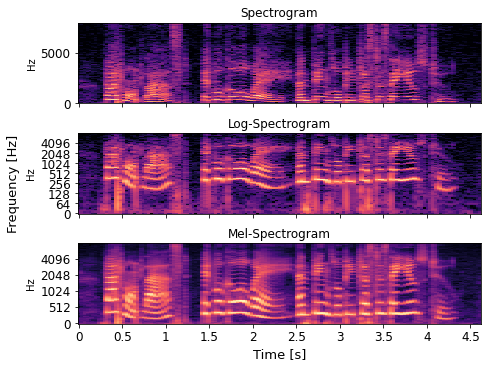

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, layout="compressed")
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig.set_figwidth(480*px)
fig.set_figheight(5)
D = librosa.amplitude_to_db(np.abs(librosa.stft(ds_libri["audio"][idx])), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=16000, ax=ax[0])
#ax[0].set(title='Linear-Frequency Spectrogram')
ax[0].label_outer()
#ax[0].set_ylabel("Frequency [Hz]", fontsize=13)
ax[0].tick_params(axis="both", which="major", labelsize=12)
ax[0].set(title='Spectrogram')

D = librosa.amplitude_to_db(np.abs(librosa.stft(ds_libri["audio"][idx])), ref=np.max)
img = librosa.display.specshow(D, y_axis='log', x_axis='time',
                               sr=16000, ax=ax[1])
#ax[0].set(title='Linear-Frequency Spectrogram')
ax[1].label_outer()
#ax[1].set_ylabel("Frequency [Hz]", fontsize=13)
ax[1].tick_params(axis="both", which="major", labelsize=12)
ax[1].set(title='Log-Spectrogram')

# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=ds_libri["audio"][idx], sr=16000, n_mels=128,
                                    fmax=8000)

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax[2])
#fig.colorbar(img, ax=ax, format='%+2.0f dB', orientation="horizontal", label="Magnitude")
ax[2].set(title='Mel-Spectrogram')
ax[2].label_outer()
ax[2].set_xlabel("Time [s]", fontsize=13)
#ax[2].set_ylabel("Frequency [Hz]", fontsize=13)
ax[2].tick_params(axis="both", which="major", labelsize=12)

fig.supylabel('Frequency [Hz]', fontsize=13)
plt.savefig("figs/spectrograms.pdf")
plt.show()